# Multi-modal behavior classification

# Warning
### Before running the code you need to create a folder in google drive with the name Colab and put a copy of the following folder inside: *******

# Synchronizing with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/Colab/ST_project'

Mounted at /content/gdrive


# Libraries

### Installing libraries

In [ ]:
!pip install transformers
!pip install resampy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.7 MB/s eta 0:00:00


### Importing libraries

In [ ]:
1 # Utilitaries
import os
import numpy as np
import pandas as pd
import soundfile as sf 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import resampy
import copy
import warnings
import re
import pickle

# Deep learning libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score
from collections import OrderedDict
from tqdm import tqdm
from transformers import BertModel, AutoTokenizer, get_linear_schedule_with_warmup

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

%matplotlib inline

Device:  cuda


# Hyperparameters

### Emotions and model selection

In [ ]:
# You can choose the emotions in ['neu', 'fru', 'sur', 'ang', 'hap', 'sad', 'exc', 'oth', 'fea', 'dis']
EMOTIONS = ['neu', 'fru', 'ang', 'sad', 'exc'] 
MODEL_SELECT = "both" # audio, text or both

### Others hyperparameters

In [ ]:
# Hyperparameters used in feature and example generation.
NUM_FRAMES = 96*2
NUM_MELS = 64*2
EXAMPLE_SIZE = 3 # Time of each frame
READ_OR_GEN = True # True -> Read the data. False -> Generate the data (Around one hour). If example_size!=3, put READ_OR_GEN = False


# Hyperparameters used in training.
LEARNING_RATE = 2e-5 # Learning rate for the Adam optimizer.
BATCH_SIZE = 32
NUM_EPOCHS = 50
OPTIONS = 1
SEED = 71


# Configurating some parameters
torch.manual_seed(SEED)
np.random.seed(SEED)
EMOTIONS = {emo: i for i, emo in enumerate(EMOTIONS)}
EMBEDDING_SIZE = len(EMOTIONS)  # Size of embedding layer.

# Dataclasses

### Iemocap_dataset class

In [ ]:
class Iemocap_dataset(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emotions = {'neu': 0, 'fru': 1, 'sur': 2, 'ang': 3, 'hap': 4, 'sad': 5, 'exc': 6, 'oth': 7, 'fea': 8, 'dis': 9}
        self.EXAMPLE_SIZE = EXAMPLE_SIZE

    def get_labels(self, annot_file, file_name):
        
        f = open(annot_file, 'r').read()
        f = f.split('\n')
        f = f[2:]
        
        for data in f:
            
            if len(data) > 0:
                if data[0] == '[':
                    data2 = data.split('\t')
                    
                    if data2[1] == file_name:
                        emo = data2[2]
                        vad = data2[3][1:-1].split(', ')
                        return emo, [float(x) for x in vad]
            
        raise ValueError('Label not found')


    def make_chunks_of_n_seconds(self, wav_data, sr):
      size = wav_data.shape[0]
      # Convert to mono.
      if len(wav_data.shape) > 1:
        wav_data = np.mean(wav_data, axis=1)
      if size>=(sr*self.EXAMPLE_SIZE):
        data = wav_data[:sr*self.EXAMPLE_SIZE]
      else:
        data = np.concatenate((wav_data, np.zeros(sr*self.EXAMPLE_SIZE-size)))
      return data



    def gen_chunks(self, df, root_path):
      df = df[df["FA_wd_path"] != "missing"]
      data_size = df.shape[0]
      pre_processed_data = []
      labels = []
      all_chunks = []
      all_texts = []

      for index, row in df.iterrows():
          print(f'{index}/{data_size}')
          session = row['session']
          method = row['method']
          gender = row['gender']
          emotion = row['emotion']
          n_annot = row['emotion']
          agreement = row['agreement']
          wav_path = row['wav_path']
          text_path = row['FA_wd_path']
          _, file_name = os.path.split(wav_path)
          
          annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                                    'Session'+str(session), 
                                    'dialog', 'EmoEvaluation', 
                                    file_name[:-9] + '.txt')
          
          # get labels
          emo, vad = self.get_labels(annot_file, file_name[:-4])

          # Get audio and make pre-processing 
          if (emo in self.emotions.keys()):
            emo_index = self.emotions[emo]
            wavfile = os.path.join(root_path, wav_path)
            wav_data, sr = sf.read(wavfile, dtype='int16')
            samples = wav_data / 32768.0
            chunks = self.make_chunks_of_n_seconds(wav_data, sr)

            text_file = os.path.join(root_path, text_path)
            text_data = self.extract_words(df, text_file)

            all_chunks.append(chunks)
            all_texts.append(text_data)
            labels.append(emo_index)


      all_chunks = np.row_stack(all_chunks)
      all_texts = np.concatenate(all_texts)
      labels = np.array(labels)
      return all_chunks, all_texts, labels


    def extract_words(self, df, path):
        def match_regex_brackets(word):
            '''
            Returns true if the word is of the format "<word>"
            '''
            bracket_filter = '<[^>]+>'
            p = re.compile(bracket_filter)
            return p.match(word) != None

        def remove_digits_and_parentheses(word):
            new_word = ''.join(c for c in word if c.isalpha() or c.isspace())
            return new_word

        new_df = df[df["FA_wd_path"] != "missing"]
        
        add_words= []
        with open(path) as file:
            lines = file.readlines()

        words = []
        for line in lines[1:-1]:
            line_split = line.strip().split()
            word = line_split[3]
            words.append(word)      

        '''
        Preprocesses the words from word_list
        '''
        processed_words = []

        for word in words:
            if not match_regex_brackets(word):
                new_word = remove_digits_and_parentheses(word)
                processed_words.append(new_word)
        processed_words=(' ').join(processed_words)   
        add_words.append(processed_words)     
        return add_words  


    def select_emotions(self, x, y, new_emotions, return_tensor = True):
      n_classes = len(self.emotions.keys())
      masks_class_list = [y==i for i in range(n_classes)]
      
      inverse_new_emotions = {v: k for k, v in new_emotions.items()}
      inverse_emotions ={v: k for k, v in self.emotions.items()}
      new_index = [self.emotions[inverse_new_emotions[i]] for i in range(len(inverse_new_emotions.keys()))]   

      xclass_list = [x[masks_class_list[new_index[i]]] for i in range(len(new_emotions.keys()))]
      yclass_list = [i*np.ones(x[masks_class_list[new_index[i]]].shape[0]) for i in range(len(new_emotions.keys()))]

      if isinstance(xclass_list[0][0], str):
        x = np.concatenate((xclass_list))
      else:
        x = np.row_stack(xclass_list)
      y = np.concatenate(yclass_list)
   
      return x, y

### Preprocessing audio class

In [ ]:
class Preprocess_audio(Dataset):
    def __init__(self, data: np.array):
        super().__init__()
        # Mel spectrum constants and functions.
        self.data = data
        self.MEL_BREAK_FREQUENCY_HERTZ = 700.0
        self.MEL_HIGH_FREQUENCY_Q = 1127.0
        self.MEL_MIN_HZ = 725
        self.MEL_MAX_HZ = 7500
        self.EXAMPLE_SIZE = EXAMPLE_SIZE # seconds
        self.EXAMPLE_WINDOW_SECONDS = 0.96*self.EXAMPLE_SIZE
        self.EXAMPLE_HOP_SECONDS = 0.96
        self.SAMPLE_RATE = 16000

        self.NUM_FRAMES = NUM_FRAMES/self.EXAMPLE_SIZE  # Frames in input mel-spectrogram patch for each second
        self.NUM_BANDS = NUM_MELS  # Frequency bands in input mel-spectrogram patch.
        self.STFT_WINDOW_LENGTH_SECONDS = 0.025
        self.STFT_HOP_LENGTH_SECONDS = 0.010*96/self.NUM_FRAMES
        self.NUM_MEL_BINS = self.NUM_BANDS


    def frame(self, data, window_length, hop_length):
      """Convert array into a sequence of successive possibly overlapping frames.
      An n-dimensional array of shape (num_samples, ...) is converted into an
      (n+1)-D array of shape (num_frames, window_length, ...), where each frame
      starts hop_length points after the preceding one.
      This is accomplished using stride_tricks, so the original data is not
      copied.  However, there is no zero-padding, so any incomplete frames at the
      end are not included.
      Args:
        data: np.array of dimension N >= 1.
        window_length: Number of samples in each frame.
        hop_length: Advance (in samples) between each window.
      Returns:
        (N+1)-D np.array with as many rows as there are complete frames that can be
        extracted.
      """
      num_samples = data.shape[0]
      num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
      shape = (num_frames, window_length) + data.shape[1:]
      strides = (data.strides[0] * hop_length,) + data.strides
      return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


    def periodic_hann(self, window_length):
      """Calculate a "periodic" Hann window.
      The classic Hann window is defined as a raised cosine that starts and
      ends on zero, and where every value appears twice, except the middle
      point for an odd-length window.  Matlab calls this a "symmetric" window
      and np.hanning() returns it.  However, for Fourier analysis, this
      actually represents just over one cycle of a period N-1 cosine, and
      thus is not compactly expressed on a length-N Fourier basis.  Instead,
      it's better to use a raised cosine that ends just before the final
      zero value - i.e. a complete cycle of a period-N cosine.  Matlab
      calls this a "periodic" window. This routine calculates it.
      Args:
        window_length: The number of points in the returned window.
      Returns:
        A 1D np.array containing the periodic hann window.
      """
      return 0.5 - (0.5 * np.cos(2 * np.pi / window_length *
                                np.arange(window_length)))


    def stft_magnitude(self, signal, fft_length,
                      hop_length=None,
                      window_length=None):
      """Calculate the short-time Fourier transform magnitude.
      Args:
        signal: 1D np.array of the input time-domain signal.
        fft_length: Size of the FFT to apply.
        hop_length: Advance (in samples) between each frame passed to FFT.
        window_length: Length of each block of samples to pass to FFT.
      Returns:
        2D np.array where each row contains the magnitudes of the fft_length/2+1
        unique values of the FFT for the corresponding frame of input samples.
      """
      frames = self.frame(signal, window_length, hop_length)
      # Apply frame window to each frame. We use a periodic Hann (cosine of period
      # window_length) instead of the symmetric Hann of np.hanning (period
      # window_length-1).
      window = self.periodic_hann(window_length)
      windowed_frames = frames * window
      return np.abs(np.fft.rfft(windowed_frames, int(fft_length)))





    def hertz_to_mel(self, frequencies_hertz):
      """Convert frequencies to mel scale using HTK formula.
      Args:
        frequencies_hertz: Scalar or np.array of frequencies in hertz.
      Returns:
        Object of same size as frequencies_hertz containing corresponding values
        on the mel scale.
      """
      return self.MEL_HIGH_FREQUENCY_Q * np.log(
          1.0 + (frequencies_hertz / self.MEL_BREAK_FREQUENCY_HERTZ))


    def spectrogram_to_mel_matrix(self, num_mel_bins=20,
                                  num_spectrogram_bins=129,
                                  audio_sample_rate=8000,
                                  lower_edge_hertz=125.0,
                                  upper_edge_hertz=3800.0):
      """Return a matrix that can post-multiply spectrogram rows to make mel.
      Returns a np.array matrix A that can be used to post-multiply a matrix S of
      spectrogram values (STFT magnitudes) arranged as frames x bins to generate a
      "mel spectrogram" M of frames x num_mel_bins.  M = S A.
      The classic HTK algorithm exploits the complementarity of adjacent mel bands
      to multiply each FFT bin by only one mel weight, then add it, with positive
      and negative signs, to the two adjacent mel bands to which that bin
      contributes.  Here, by expressing this operation as a matrix multiply, we go
      from num_fft multiplies per frame (plus around 2*num_fft adds) to around
      num_fft^2 multiplies and adds.  However, because these are all presumably
      accomplished in a single call to np.dot(), it's not clear which approach is
      faster in Python.  The matrix multiplication has the attraction of being more
      general and flexible, and much easier to read.
      Args:
        num_mel_bins: How many bands in the resulting mel spectrum.  This is
          the number of columns in the output matrix.
        num_spectrogram_bins: How many bins there are in the source spectrogram
          data, which is understood to be fft_size/2 + 1, i.e. the spectrogram
          only contains the nonredundant FFT bins.
        audio_sample_rate: Samples per second of the audio at the input to the
          spectrogram. We need this to figure out the actual frequencies for
          each spectrogram bin, which dictates how they are mapped into mel.
        lower_edge_hertz: Lower bound on the frequencies to be included in the mel
          spectrum.  This corresponds to the lower edge of the lowest triangular
          band.
        upper_edge_hertz: The desired top edge of the highest frequency band.
      Returns:
        An np.array with shape (num_spectrogram_bins, num_mel_bins).
      Raises:
        ValueError: if frequency edges are incorrectly ordered or out of range.
      """
      nyquist_hertz = audio_sample_rate / 2.
      if lower_edge_hertz < 0.0:
        raise ValueError("lower_edge_hertz %.1f must be >= 0" % lower_edge_hertz)
      if lower_edge_hertz >= upper_edge_hertz:
        raise ValueError("lower_edge_hertz %.1f >= upper_edge_hertz %.1f" %
                        (lower_edge_hertz, upper_edge_hertz))
      if upper_edge_hertz > nyquist_hertz:
        raise ValueError("upper_edge_hertz %.1f is greater than Nyquist %.1f" %
                        (upper_edge_hertz, nyquist_hertz))
      spectrogram_bins_hertz = np.linspace(0.0, nyquist_hertz, num_spectrogram_bins)
      spectrogram_bins_mel = self.hertz_to_mel(spectrogram_bins_hertz)
      # The i'th mel band (starting from i=1) has center frequency
      # band_edges_mel[i], lower edge band_edges_mel[i-1], and higher edge
      # band_edges_mel[i+1].  Thus, we need num_mel_bins + 2 values in
      # the band_edges_mel arrays.
      band_edges_mel = np.linspace(self.hertz_to_mel(lower_edge_hertz),
                                  self.hertz_to_mel(upper_edge_hertz), num_mel_bins + 2)
      # Matrix to post-multiply feature arrays whose rows are num_spectrogram_bins
      # of spectrogram values.
      mel_weights_matrix = np.empty((num_spectrogram_bins, num_mel_bins))
      for i in range(num_mel_bins):
        lower_edge_mel, center_mel, upper_edge_mel = band_edges_mel[i:i + 3]
        # Calculate lower and upper slopes for every spectrogram bin.
        # Line segments are linear in the *mel* domain, not hertz.
        lower_slope = ((spectrogram_bins_mel - lower_edge_mel) /
                      (center_mel - lower_edge_mel))
        upper_slope = ((upper_edge_mel - spectrogram_bins_mel) /
                      (upper_edge_mel - center_mel))
        # .. then intersect them with each other and zero.
        mel_weights_matrix[:, i] = np.maximum(0.0, np.minimum(lower_slope,
                                                              upper_slope))
      # HTK excludes the spectrogram DC bin; make sure it always gets a zero
      # coefficient.
      mel_weights_matrix[0, :] = 0.0
      return mel_weights_matrix


    def log_mel_spectrogram(self, data,
                            audio_sample_rate=8000,
                            log_offset=0.0,
                            window_length_secs=0.025,
                            hop_length_secs=0.010,
                            **kwargs):
      """Convert waveform to a log magnitude mel-frequency spectrogram.
      Args:
        data: 1D np.array of waveform data.
        audio_sample_rate: The sampling rate of data.
        log_offset: Add this to values when taking log to avoid -Infs.
        window_length_secs: Duration of each window to analyze.
        hop_length_secs: Advance between successive analysis windows.
        **kwargs: Additional arguments to pass to spectrogram_to_mel_matrix.
      Returns:
        2D np.array of (num_frames, num_mel_bins) consisting of log mel filterbank
        magnitudes for successive frames.
      """
      window_length_samples = int(round(audio_sample_rate * window_length_secs))
      hop_length_samples = int(round(audio_sample_rate * hop_length_secs))
      fft_length = 2 ** int(np.ceil(np.log(window_length_samples) / np.log(2.0)))
      spectrogram = self.stft_magnitude(
          data,
          fft_length=fft_length,
          hop_length=hop_length_samples,
          window_length=window_length_samples)
      mel_spectrogram = np.dot(spectrogram, self.spectrogram_to_mel_matrix(
          num_spectrogram_bins=spectrogram.shape[1],
          audio_sample_rate=audio_sample_rate, **kwargs))
      return np.log(mel_spectrogram + log_offset)


    def make_chunks_of_n_seconds(self, wav_data, sr):
      size = wav_data.shape[0]
      # Convert to mono.
      if len(wav_data.shape) > 1:
        wav_data = np.mean(wav_data, axis=1)
      if size>=(sr*self.EXAMPLE_SIZE):
        data = wav_data[:sr*self.EXAMPLE_SIZE]
      else:
        data = np.concatenate((wav_data, np.zeros(sr*self.EXAMPLE_SIZE-size)))
      return data


    def wave_to_examples(self, data, sample_rate, return_tensor = False, gen_chunk = False):
        """Converts audio waveform into an array of examples for VGGish.
      Args:
        data: np.array of either one dimension (mono) or two dimensions
          (multi-channel, with the outer dimension representing channels).
          Each sample is generally expected to lie in the range [-1.0, +1.0],
          although this is not required.
        sample_rate: Sample rate of data.
        return_tensor: Return data as a Pytorch tensor ready for VGGish
      Returns:
        3-D np.array of shape [num_examples, num_frames, num_bands] which represents
        a sequence of examples, each of which contains a patch of log mel
        spectrogram, covering num_frames frames of audio and num_bands mel frequency
        bands, where the frame length is vggish_params.STFT_HOP_LENGTH_SECONDS.
      """
        # Convert to mono.
        if len(data.shape) > 1:
            data = np.mean(data, axis=1)
        # Resample to the rate assumed by VGGish.
        if sample_rate != self.SAMPLE_RATE:
            data = resampy.resample(data, sample_rate, self.SAMPLE_RATE)
        if gen_chunk:
              data = self.make_chunks_of_n_seconds(data, sample_rate)

        # Compute log mel spectrogram features.
        log_mel = self.log_mel_spectrogram(
            data,
            audio_sample_rate=self.SAMPLE_RATE,
            log_offset=0.01,
            window_length_secs=self.STFT_WINDOW_LENGTH_SECONDS,
            hop_length_secs=self.STFT_HOP_LENGTH_SECONDS,
            num_mel_bins=self.NUM_MEL_BINS,
            lower_edge_hertz=self.MEL_MIN_HZ,
            upper_edge_hertz=self.MEL_MAX_HZ)

        # Frame features into examples.
        features_sample_rate = 1.0 / self.STFT_HOP_LENGTH_SECONDS
        example_window_length = int(round(
            self.EXAMPLE_WINDOW_SECONDS * features_sample_rate))

        example_hop_length = int(round(
            self.EXAMPLE_HOP_SECONDS * features_sample_rate))

        log_mel_examples = self.frame(
            log_mel,
            window_length=example_window_length,
            hop_length=example_hop_length)

        if return_tensor:
            log_mel_examples = torch.tensor(
                log_mel_examples, requires_grad=True)[:, None, :, :].float()
            log_mel = torch.tensor(
                log_mel, requires_grad=True)[None, :, :].float()
            
        return log_mel_examples


    def __len__(self):
      return self.data.shape[0]

    def __getitem__(self, index: int):
      return self.wave_to_examples(self.data[index], self.SAMPLE_RATE, True)


'''
    def forward(self, data):
      data = data.detach().numpy()
      data = [self.wave_to_examples(data[i], SAMPLE_RATE, True) for i in range(data.shape[0])]
      data = torch.row_stack(data).detach()
      return data
'''

'\n    def forward(self, data):\n      data = data.detach().numpy()\n      data = [self.wave_to_examples(data[i], SAMPLE_RATE, True) for i in range(data.shape[0])]\n      data = torch.row_stack(data).detach()\n      return data\n'

### Preprocessing text class

In [ ]:
class Preprocess_text(Dataset):

  def __init__(
    self, 
    data: np.array
    ):
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    self.data = data
    self.size = self.data.shape[0]
    self.max_token_len = 128
    
  def __len__(self):
    return self.size

  def __getitem__(self, index: int):
    phrases = self.data[index]
    encoding = self.tokenizer.encode_plus(
      phrases,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return encoding["input_ids"].flatten(), encoding["attention_mask"].flatten()

'''
def __getitem__(self, index: int):
  data_row = self.data.iloc[index]

  phrases = data_row.Words
  labels = data_row[self.data.columns.tolist()[1:]]

  encoding = self.tokenizer.encode_plus(
    phrases,
    add_special_tokens=True,
    max_length=self.max_token_len,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
  )
  '''


    

'\ndef __getitem__(self, index: int):\n  data_row = self.data.iloc[index]\n\n  phrases = data_row.Words\n  labels = data_row[self.data.columns.tolist()[1:]]\n\n  encoding = self.tokenizer.encode_plus(\n    phrases,\n    add_special_tokens=True,\n    max_length=self.max_token_len,\n    return_token_type_ids=False,\n    padding="max_length",\n    truncation=True,\n    return_attention_mask=True,\n    return_tensors=\'pt\',\n  )\n  '

### Preprocess data class

In [ ]:
class Preprocess_data(Dataset):

  def __init__(
    self, 
    audio_data: np.array,
    text_data: np.array,
    labels_data: np.array,
    ):
    super().__init__()

    self.text_class = Preprocess_text(text_data)
    self.size = audio_data.shape[0]
    self.labels = labels_data
    self.audio_class = Preprocess_audio(audio_data)


  def __len__(self):
    return self.size

  def __getitem__(self, index: int):
    audio = self.audio_class.__getitem__(index).flatten()
    inputs_ids, attention_mask = self.text_class.__getitem__(index)
    label = torch.tensor(self.labels[index]).reshape(1, 1, 1).to(device)
    concatenation = torch.cat((audio, inputs_ids, attention_mask)).reshape(1, -1).to(device)

    return concatenation, label

 # Training functions

In [ ]:
def train_model_one_epoch(model, training_set, iepoch, opt_state):
    model = model.train()
    train_losses = []
    train_accuracy = []

    with tqdm(training_set, unit="batch") as tepoch:
      for mini_batch in tepoch:
        tepoch.set_description(f"Epoch {iepoch}: Training")

        opt_state['optimizer'].zero_grad()

        # Forward pass
        x, labels = mini_batch
        x = x.to(device)
        labels = labels.cpu()
        mini_batch_pred = model(x)
        y_onehot = np.zeros((labels.shape[0], EMBEDDING_SIZE))
        
        # To onehot representation
        index = (np.array(labels).reshape(labels.shape[0], )).astype(np.int64)
        y_onehot[np.arange(labels.shape[0]), index] = 1
        y_onehot = torch.Tensor(y_onehot).to(device)
        loss = model.loss_function(mini_batch_pred, y_onehot)

        # Weights updating
        loss.backward()
        opt_state['optimizer'].step()
        opt_state['lr_scheduler']['scheduler'].step()

        # Compute accuracy
        acc = torch.sum(torch.argmax(mini_batch_pred, axis=1)==labels.to(device).flatten()*1)
        acc = acc/labels.shape[0]

        # Update loss and accuracy
        train_losses.append(loss.item())
        train_accuracy.append(acc.item())
        tepoch.set_postfix(loss=np.mean(train_losses), accuracy = np.mean(train_accuracy))

    return model, opt_state, train_losses, train_accuracy


def eval_model_one_epoch(model, validation_set, iepoch, opt_state):
    model_eval = model.eval()
    val_losses = []
    val_accuracy = []

    with torch.no_grad():
      with tqdm(validation_set, unit="batch") as tepoch:
          for mini_batch in tepoch:
            tepoch.set_description(f"Epoch {iepoch}: Validation")

            opt_state['optimizer'].zero_grad()
    
            # Forward pass
            x, labels = mini_batch
            x = x.to(device)
            labels = labels.cpu()
            mini_batch_pred = model_eval(x)

            # To onehot representation
            y_onehot = np.zeros((labels.shape[0], EMBEDDING_SIZE))
            index = (np.array(labels).reshape(labels.shape[0], )).astype(np.int64)
            y_onehot[np.arange(labels.shape[0]), index] = 1
            y_onehot = torch.Tensor(y_onehot).to(device)

            # Compute loss and accuracy
            loss = model_eval.loss_function(mini_batch_pred, y_onehot)
            acc = torch.sum(torch.argmax(mini_batch_pred, axis=1)==labels.to(device).flatten()*1)
            acc = acc/labels.shape[0]

            # Update loss and accuracy
            val_losses.append(loss.item())
            val_accuracy.append(acc.item())
            tepoch.set_postfix(loss=np.mean(val_losses), accuracy = np.mean(val_accuracy))

    return opt_state, val_losses, val_accuracy


def train_model(model, train_dataset, val_dataset, n_epochs, LEARNING_RATE, path):
  #optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
  steps_per_epoch = train_dataset.__len__()//BATCH_SIZE
  n_training_steps = (n_epochs*steps_per_epoch)
  optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
  #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= n_training_steps//10, num_training_steps=n_training_steps*10)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps= n_training_steps//5, num_training_steps=n_training_steps*100000)
  opt_state = dict(optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval='step'))
  history = dict(train_loss=[], val_loss=[], train_accuracy=[], val_accuracy=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = np.inf
  best_accuracy = -np.inf

  for epoch in range(1, n_epochs + 1):
    # One epoch optimisation 
    model, opt_state, train_losses, train_accuracies = train_model_one_epoch(model, train_dataset, epoch, opt_state)
    opt_state, val_losses, val_accuracies = eval_model_one_epoch(model, val_dataset, epoch, opt_state)

    # Updating loss  
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    # Updating accuracy
    train_accuracy = np.mean(train_accuracies)
    val_accuracy = np.mean(val_accuracies)

    # Updating training history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    # Storing the best model
    if val_accuracy > best_accuracy and val_loss < best_loss:
      best_loss = val_loss
      best_accuracy = val_accuracy
      best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  torch.save(model, os.path.join(path, 'best_model.zip'))
  torch.save(history, os.path.join(path, 'history.zip'))

  return model.eval(), history


# Dataset

### Generate or read

In [ ]:
if READ_OR_GEN:
  concatenated_audio = pickle.load(open(os.path.join(root_path, 'Data/audio'), "rb"))
  concatenated_text = pickle.load(open(os.path.join(root_path, 'Data/text'), "rb"))
  concatenated_labels = pickle.load(open(os.path.join(root_path, 'Data/labels'), "rb"))

else:
  iemocappath = os.path.join(root_path, 'IEMOCAP_full_release_withoutVideos_sentenceOnly')
  df = pd.read_csv(os.path.join(iemocappath, 'iemocap.csv'))
  concatenated_audio, concatenated_text, concatenated_labels = Iemocap_dataset().gen_chunks(df, iemocappath)
  # Save audio, text and labels
  pickle.dump(concatenated_audio, open(os.path.join(root_path, 'Data/audio'), "wb"))
  pickle.dump(concatenated_text, open(os.path.join(root_path, 'Data/text'), "wb"))
  pickle.dump(concatenated_labels, open(os.path.join(root_path, 'Data/labels'), "wb"))


print("Shape audio: ", concatenated_audio.shape)
print("Shape text: ", concatenated_text.shape)
print("Shape labels: ", concatenated_labels.shape)

Shape audio:  (7531, 48000)
Shape text:  (7531,)
Shape labels:  (7531,)


### Selecting emotions

In [ ]:
concatenated_audio, __ = Iemocap_dataset().select_emotions(concatenated_audio, concatenated_labels, EMOTIONS)
concatenated_text, concatenated_labels = Iemocap_dataset().select_emotions(concatenated_text, concatenated_labels, EMOTIONS)

print("Number of chunks: ", concatenated_audio.shape)
print("Number of texts: ", concatenated_text.shape)
print("Number of labels: ", concatenated_labels.shape)

Number of chunks:  (6784, 48000)
Number of texts:  (6784,)
Number of labels:  (6784,)


# Analysing the dataset

### Compute weights

In [ ]:
# The dataset is unbalanced, so we use class weights in cross entropy loss
class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(concatenated_labels),y = concatenated_labels)
class_weights=torch.tensor(class_weights,dtype=torch.float)

print("Class weights:", class_weights) 

Class weights: tensor([0.7944, 0.7338, 1.2301, 1.2517, 1.3046])


### Plot class representation

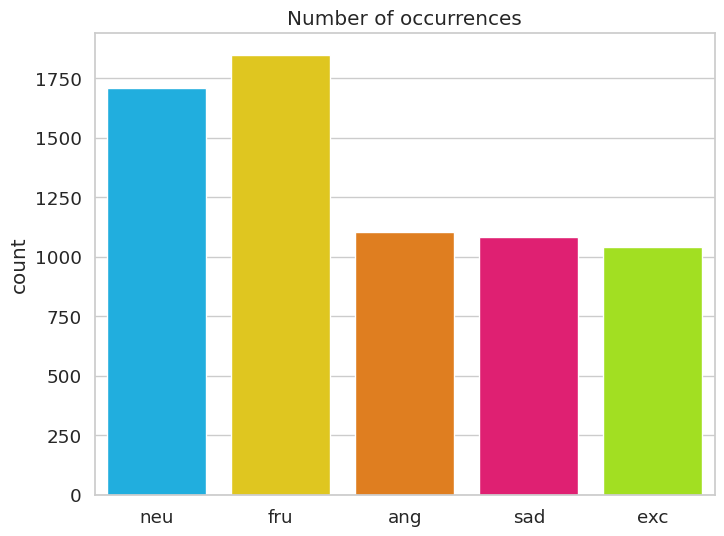

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLORS))
inverse_dict_emotions = {v: k for k, v in EMOTIONS.items()}


class_names = [inverse_dict_emotions[i] for i in range(EMBEDDING_SIZE)]
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x=concatenated_labels)
ax.set_xticklabels(class_names)
ax.set_title("Number of occurrences")
fig.savefig(os.path.join(root_path, 'Images/occurrences.png'))

### Plot spectrogram

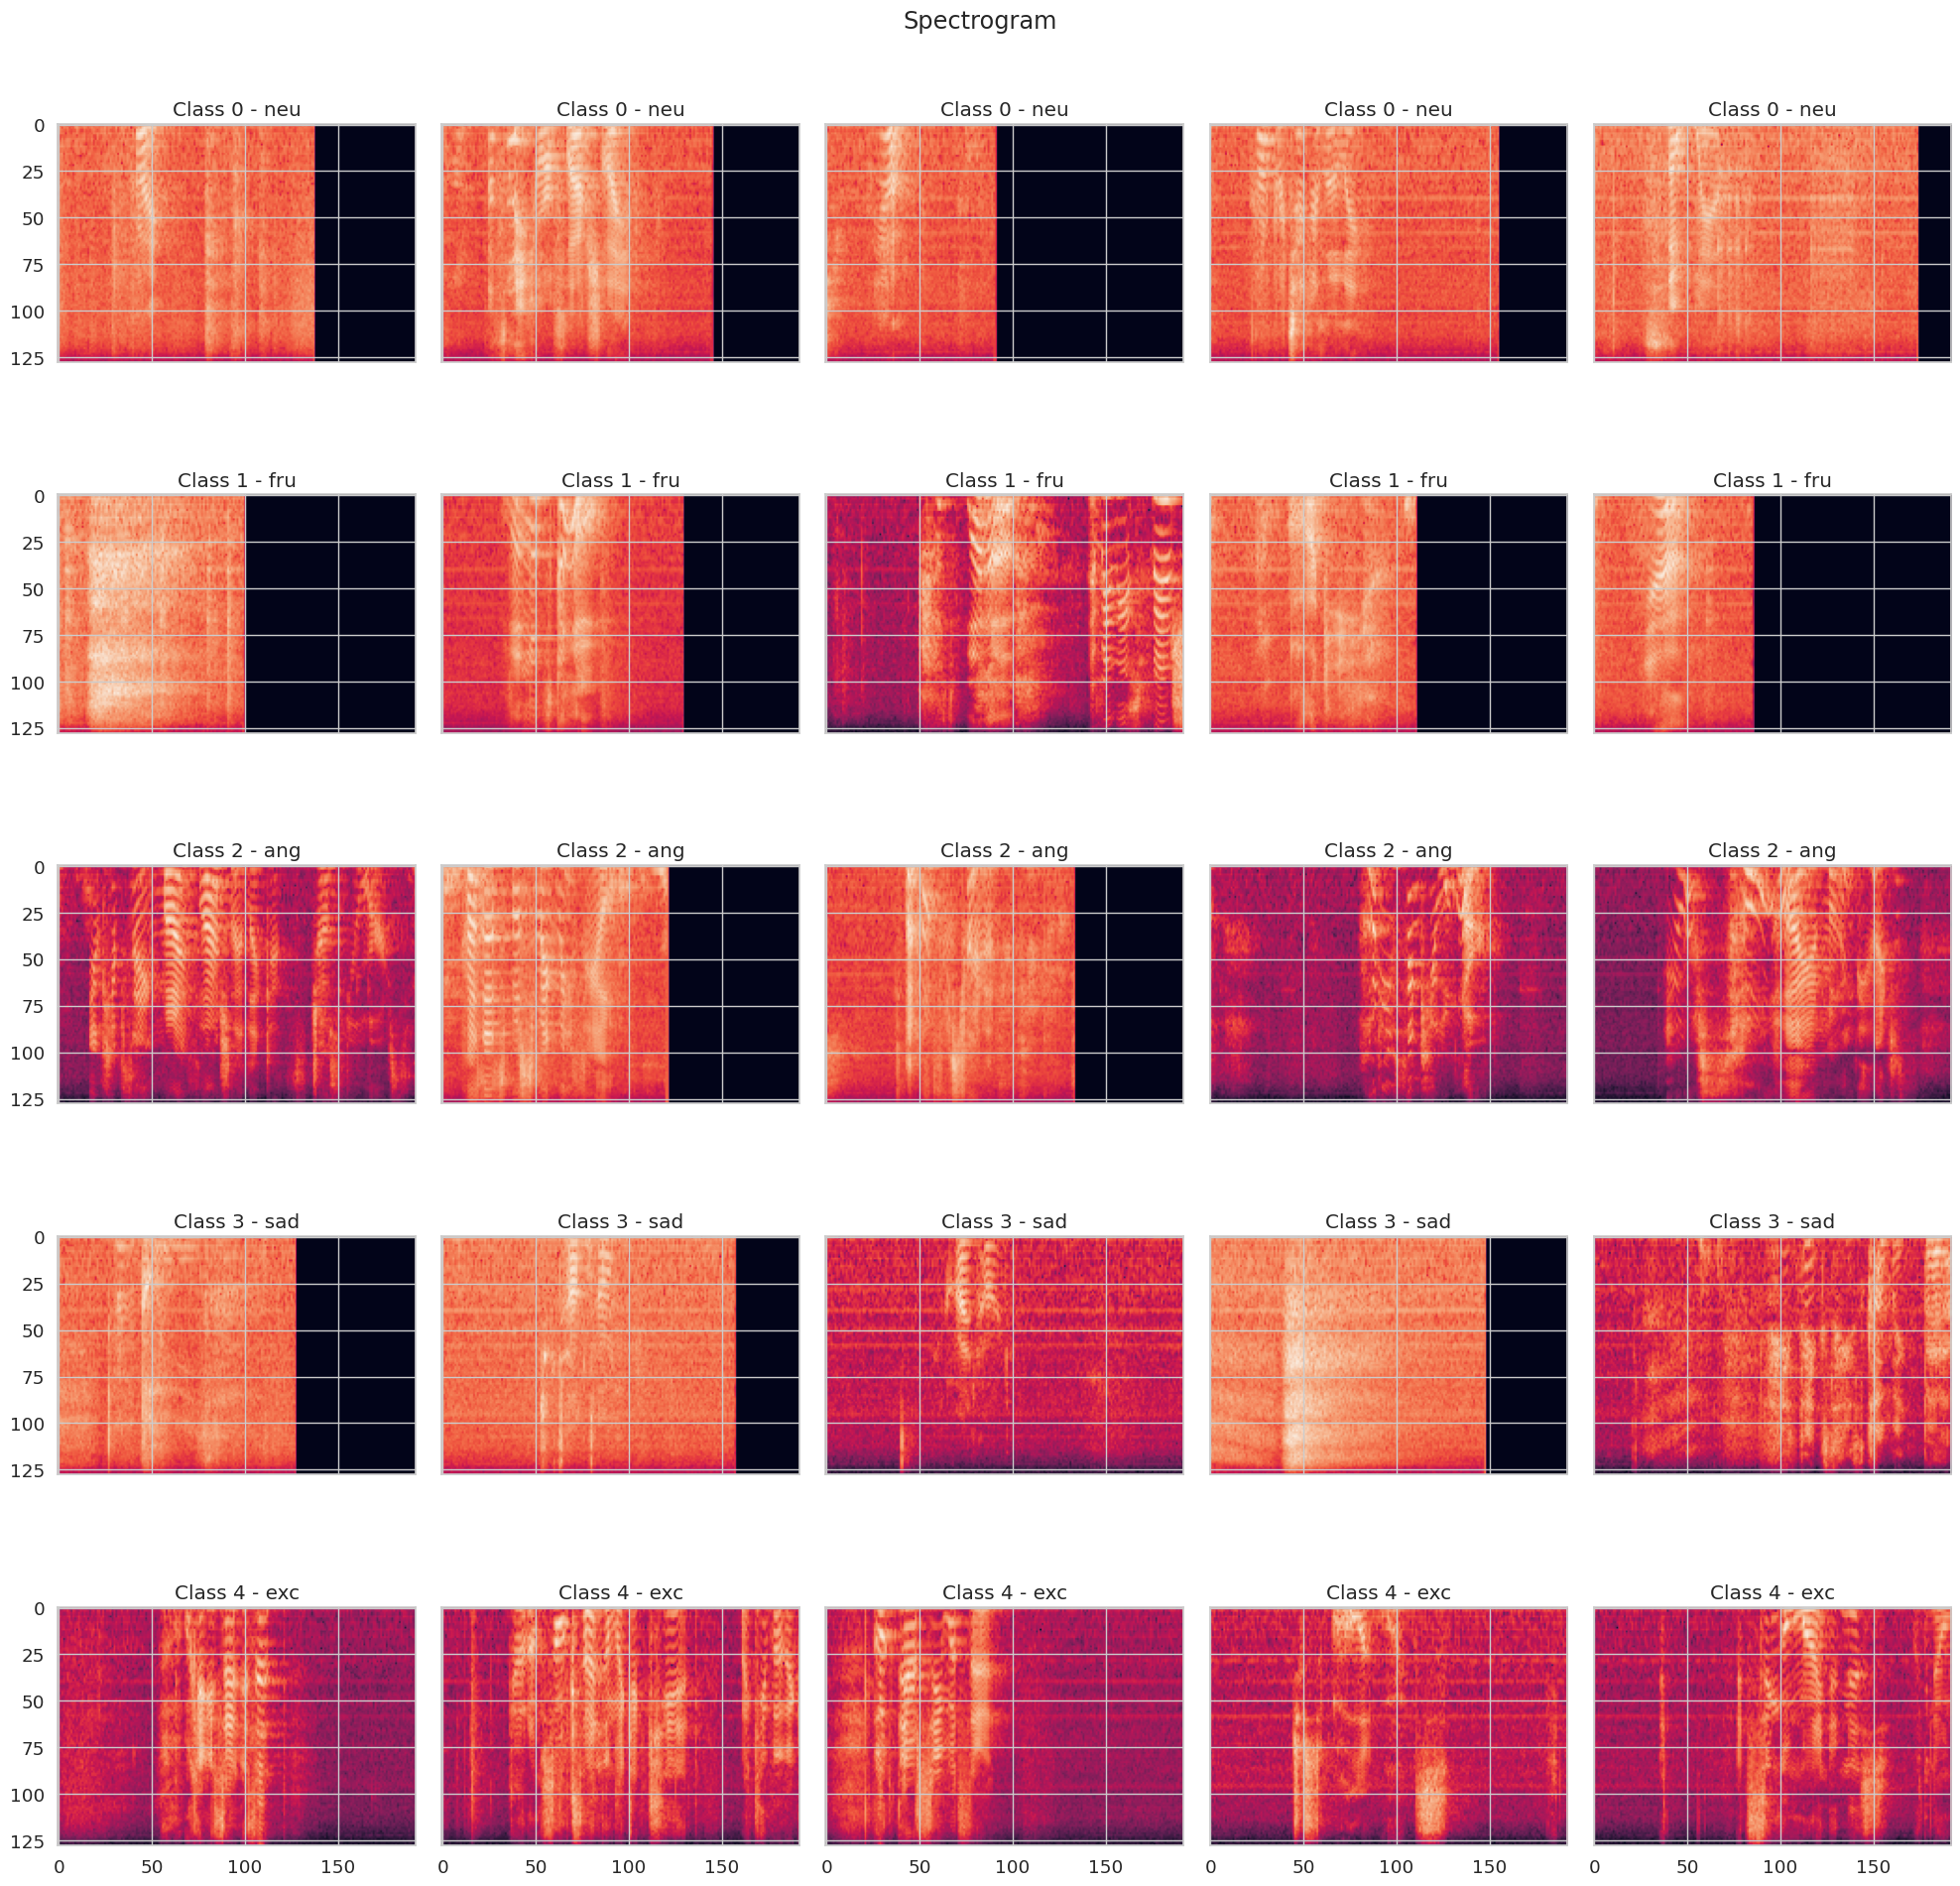

In [ ]:
inverse_dict_emotions = {v: k for k, v in EMOTIONS.items()}

rows, cols = EMBEDDING_SIZE, 5
fig, axs = plt.subplots(nrows=rows, ncols=cols, sharey=True, sharex=True, figsize=(20, 4*EMBEDDING_SIZE))
fig.suptitle('Spectrogram')
for i in range(rows):
  classk = concatenated_audio[concatenated_labels==i][:cols]
  classk = torch.row_stack([Preprocess_audio(classk).__getitem__(i) for i in range(cols)])
  for j in range(cols):
    axs[i, j].imshow(classk[j,0,:].detach().numpy().transpose())
    axs[i, j].set_title(f'Class {i} - {inverse_dict_emotions[i]}')
  
fig.tight_layout()
fig.savefig(os.path.join(root_path, 'Images/spectrogram.png'))


# Datasplit

### Shuffle

In [ ]:
index = np.random.randint(0,concatenated_labels.shape[0], size=(concatenated_labels.shape[0], ))
concatenated_audio = concatenated_audio[index]
concatenated_text = concatenated_text[index]
concatenated_labels = concatenated_labels[index]

### Split

In [ ]:
audio_training_set, audio_validation_set, text_training_set, text_validation_set, ytraining_set, yvalidation_set = train_test_split(concatenated_audio, concatenated_text, concatenated_labels, test_size=0.2, random_state=SEED)
del concatenated_audio, concatenated_text, concatenated_labels
audio_validation_set, audio_test_set, text_validation_set, text_test_set, yvalidation_set, ytest_set  = train_test_split(audio_validation_set, text_validation_set, yvalidation_set, test_size=0.5,  random_state=SEED)

# Model

### Audio model

In [ ]:
class Audio_model(torch.nn.Module):
    def __init__(self, EMBEDDING_SIZE = 5, pre_train = True, class_weights = None):
        super().__init__()
        model = torch.hub.load('harritaylor/torchvggish', model='vggish', pretrained = pre_train)

        vggish_pretrained_features = model.features
        for param in vggish_pretrained_features[:11].parameters():
              param.requires_grad = not pre_train
        for param in vggish_pretrained_features[11:].parameters():
              param.requires_grad = True
        self.features = vggish_pretrained_features

        vggish_embeddings = nn.Sequential(OrderedDict([('0', nn.Linear(32*NUM_MELS, 64)), ('1', nn.ReLU())]))

        classifier = nn.Sequential(OrderedDict([('0', nn.Linear(64, EMBEDDING_SIZE, bias = False)), ('1', nn.Softmax())]))
        self.classifier = classifier

        self.loss_function = nn.CrossEntropyLoss(weight=class_weights, reduce='mean')


    def to_embeddings(self, x):
        x = x.mean(axis=-2)
        x = x.flatten(-2,-1)
        x = self.embeddings(x)

        return x


    def forward(self, x):
        x = self.features(x)
        x = self.to_embeddings(x)
        x = self.classifier(x)

        return x


    def predict(self, x):
        x = self.forward(x)
        x = torch.argmax(x, dim=1)

        return x

### Text model

In [ ]:
class Text_model(torch.nn.Module):
    def __init__(self, EMBEDDING_SIZE = 5, class_weights = None):
        super().__init__()
        self.features = BertModel.from_pretrained("bert-base-cased", return_dict=True)
        self.embeddings = nn.Sequential(OrderedDict([('0', nn.Linear(self.features.config.hidden_size, 64)), ('1', nn.ReLU())]))
        self.classifier = nn.Sequential(OrderedDict([('0', nn.Linear(64, EMBEDDING_SIZE, bias = False)), ('1', nn.Softmax())]))
        self.loss_function = nn.CrossEntropyLoss(weight=class_weights, reduce='mean')

    def forward(self, x):
        x = x.reshape(x.shape[0], 2, x.shape[1]//2)
        input_ids, attention_mask = x[:,0,:], x[:,1,:]
        output = self.features(input_ids, attention_mask=attention_mask)
        output = self.embeddings(output.pooler_output)
        output = self.classifier(output)
          
        return output

    def predict(self, x):
        x = self.forward(x)
        x = torch.argmax(x, dim=1)

        return x


### Fusion

In [ ]:
class Architecture(torch.nn.Module):
    def __init__(self, model_select = "both", EMBEDDING_SIZE = 5, pre_train = True, class_weights = None):
        super().__init__()
        self.EMBEDDING_SIZE = EMBEDDING_SIZE
        
        # Audio
        audio_model = Audio_model(pre_train = True).features
        for param in audio_model[:11].parameters():
              param.requires_grad = False
        for param in audio_model[11:].parameters():
              param.requires_grad = True
        self.audio_model = audio_model

        # Text
        text_model = Text_model().features
        for param in text_model.parameters():
              param.requires_grad = True
        self.text_model = text_model

        # Embeddings
        self.embedding_audio = nn.Sequential(OrderedDict([('0', nn.Linear(32*NUM_MELS, 512)), ('1', nn.ReLU()), ('2', nn.Linear(512, 512)), ('3', nn.ReLU())]))
        self.embedding_text = nn.Sequential(OrderedDict([('0', nn.Linear(self.text_model.config.hidden_size, 512)), ('1', nn.ReLU()), ('2', nn.Linear(512, 512)), ('3', nn.ReLU())]))
        self.embedding_both = nn.Sequential(OrderedDict([('0', nn.Linear(32*NUM_MELS+self.text_model.config.hidden_size, 512)), ('1', nn.ReLU()), ('2', nn.Linear(512, 512)), ('3', nn.ReLU())]))

        # Classifier
        self.classifier = nn.Sequential(OrderedDict([('0', nn.Linear(512, EMBEDDING_SIZE, bias = False)), ('1', nn.Softmax())]))

        # Others parameters
        self.loss_function = nn.CrossEntropyLoss(weight=class_weights, reduce='mean')
        self.num_mels = NUM_MELS
        self.num_frames = NUM_FRAMES
        self.model_select = model_select

    def forward(self, x):
        # Audio
        x_audio = x[:, 0, :(self.num_frames*self.num_mels)]
        x_audio = x_audio.reshape(x.shape[0], 1, self.num_frames, self.num_mels)
        x_audio = self.audio_model(x_audio)
        x_audio = x_audio.mean(axis=-2).flatten(-2,-1)
        
        # Text
        x_text = x[:, 0, self.num_frames*self.num_mels:].to(torch.int)
        x_text = x_text.reshape(x_text.shape[0], 1, 2, x_text.shape[1]//2)
        input_ids, attention_mask = x_text[:,0,0,:], x_text[:,0,1,:]
        x_text = self.text_model(input_ids, attention_mask=attention_mask)
        
        if self.model_select=="audio":
          x = self.embedding_audio(x_audio)
          x = self.classifier(x)
        elif self.model_select=="text":
          x = self.embedding_text(x_text.pooler_output)
          x = self.classifier(x)
        else:
          x = torch.cat((x_audio, x_text.pooler_output), dim=1)
          x = self.embedding_both(x)
          x = self.classifier(x)

        return x


    def predict(self, x):
        x = self.forward(x)
        x = torch.argmax(x, dim=1)

        return x

# Model initialization

In [ ]:
model = Architecture(model_select = MODEL_SELECT, EMBEDDING_SIZE = EMBEDDING_SIZE, pre_train = True, class_weights = class_weights).to(device)
training_generator = DataLoader(Preprocess_data(audio_training_set, text_training_set, ytraining_set), batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
validation_generator = DataLoader(Preprocess_data(audio_validation_set, text_validation_set, yvalidation_set), batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True) # multiprocessing_context='spawn'
print(model)

Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth


  0%|          | 0.00/275M [00:00<?, ?B/s]

Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish_pca_params-970ea276.pth" to /root/.cache/torch/hub/checkpoints/vggish_pca_params-970ea276.pth


  0%|          | 0.00/177k [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Architecture(
  (audio_model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

# Training

In [ ]:
path = os.path.join(root_path, 'Checkpoints')
if OPTIONS==1:
    model, history = train_model(model, training_generator, validation_generator, NUM_EPOCHS, LEARNING_RATE, path)
else:
    model = torch.load(os.path.join(path, 'best_model.zip'))
    history = torch.load(os.path.join(path, 'history.zip'))
    model = model.to(device) 

Epoch 50: Validation: 100%|██████████| 21/21 [00:11<00:00,  1.90batch/s, accuracy=0.762, loss=1.15]


# Results

### Plot loss and accuracy at the training and validation

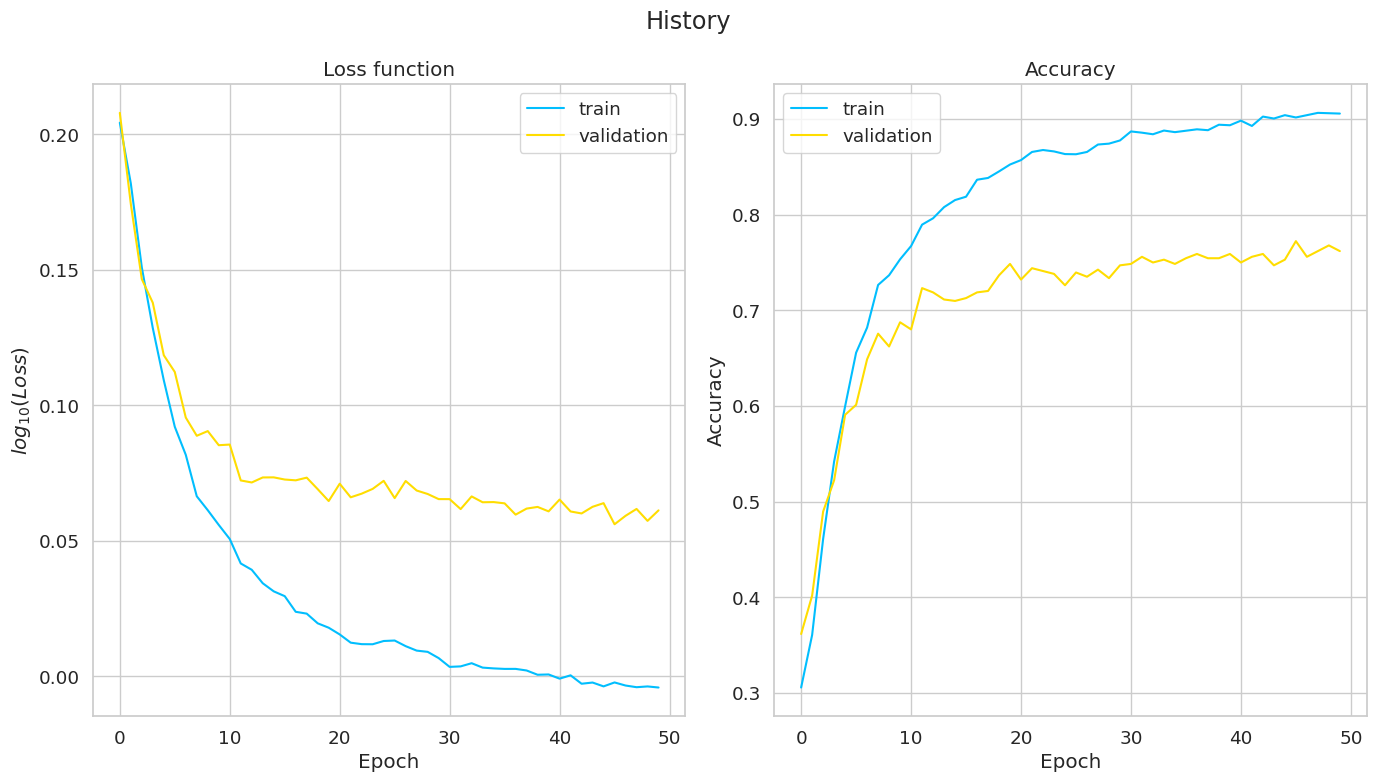

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
fig.suptitle('History')
axs[0].plot(np.log10(history['train_loss']))
axs[0].plot(np.log10(history['val_loss']))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('$log_{10}(Loss)$')
axs[0].legend(['train', 'validation'])
axs[0].set_title('Loss function')

axs[1].plot(history['train_accuracy'])
axs[1].plot(history['val_accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['train', 'validation'])
axs[1].set_title('Accuracy')

fig.tight_layout()
fig.savefig(os.path.join(root_path, 'Images/loss.png'))
plt.show()

### Accuracy test set

In [ ]:
eval_model = model.eval()
ypredict_test_set = []
for ele in range(text_test_set.shape[0]):
  #print(f'Iteration: {ele}/{text_test_set.shape[0]}')
  xtest_set = Preprocess_data(audio_test_set, text_test_set, ytest_set)[ele][0].reshape(1,1,-1)
  ypredict_test_set.append(eval_model.predict(xtest_set).to(device).item())

ypredict_test_set = np.array(ypredict_test_set, dtype=np.float32)
correct = np.sum(np.array(ypredict_test_set.flatten()==ytest_set)*1)

print("Test size:", ypredict_test_set.shape[0])
print("Accuracy:", correct/ypredict_test_set.shape[0])

Test size: 679
Accuracy: 0.7658321060382917


### Confusion matrix

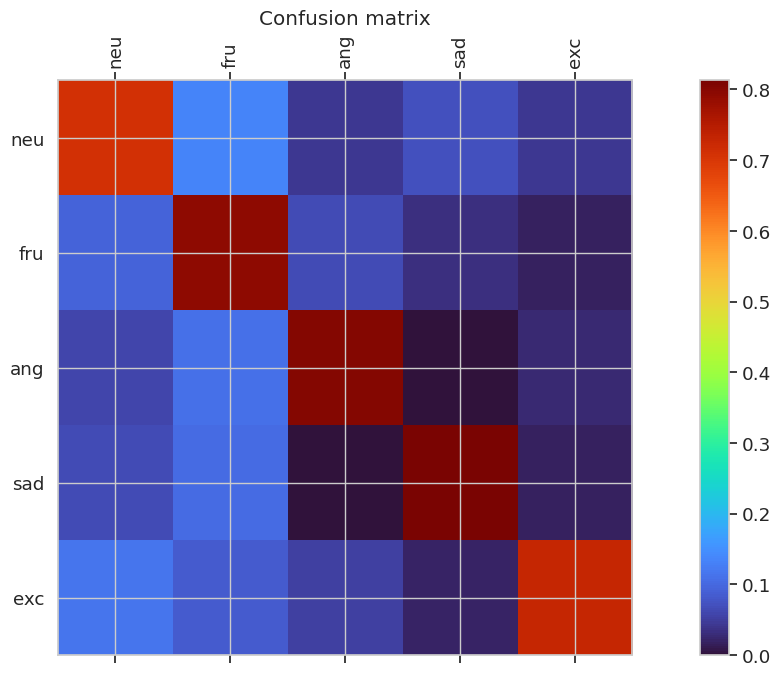

In [ ]:
confusion = confusion_matrix(ytest_set.flatten().tolist(), ypredict_test_set.tolist()).astype(np.float32)
confusion = confusion/(np.sum(confusion, axis =1)[:, None]) # Normalize by dividing every row by its sum

# Set up plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='turbo')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(EMOTIONS.keys()), rotation=90)
ax.set_yticklabels([''] + list(EMOTIONS.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.title("Confusion matrix")
fig.tight_layout()
fig.savefig(os.path.join(root_path, 'Images/confusion_matrix.png'))
plt.show()

### F1 - Score

In [ ]:
print('F1-score: ', f1_score(ytest_set, ypredict_test_set, average ='macro'))

F1-score:  0.7721006289660003


# Application to be used in the interface

In [ ]:
class Process_independent_input(torch.nn.Module):
  def __init__(self):
    super().__init__()
    

  def get_pre_processed_input(self, text_data, audio_data, audio_sr):
      audio_class = Preprocess_audio(audio_data)
      text_class = Preprocess_text(text_data)
      data = []
      for i in range(text_data.shape[0]):
        audio = audio_class.wave_to_examples(audio_data[i], audio_sr, True, True).flatten()
        inputs_ids, attention_mask = text_class.__getitem__(i)
        data.append(torch.cat((audio, inputs_ids, attention_mask)))
      concatenation = torch.row_stack(data).reshape(text_data.shape[0], 1, -1).to(device)

      return concatenation


  def make_audio_chunks(self, wav_data, sr):
    size = wav_data.shape[0]
    # Convert to mono.
    if len(wav_data.shape) > 1:
      wav_data = np.mean(wav_data, axis=1)
    if size>=(sr*EXAMPLE_SIZE):
      data = []
      for i in range(size//sr):
        new_data = wav_data[i*sr*EXAMPLE_SIZE:(i+1)*sr*EXAMPLE_SIZE]
        if new_data.shape[0]>sr:
          data.append(new_data)
      data[-1] = np.concatenate((data[-1], np.zeros(sr*EXAMPLE_SIZE - data[-1].shape[0])))
      data = np.row_stack(data)
    else:
      data = np.concatenate((wav_data, np.zeros(sr*EXAMPLE_SIZE-size))).reshape(1, -1)
      
    return data


  def predict_emotions(self, audio_data, audio_sr):
      EMOTIONS = {emo: i for i, emo in enumerate(['Neutral', 'Frustated', 'Angry', 'Sad', 'Excited'])}
      inverse_dict_emotions = {v: k for k, v in EMOTIONS.items()}
      model = torch.load(os.path.join(root_path, 'Checkpoints/best_model.zip')).to(device).eval()

      audio_chunks = self.make_audio_chunks(audio_data, audio_sr)
      text_chunks = []
      for chunk in audio_chunks:
        phrase = 'text obtained by using the translation model in chunk'   #### Fix this line using audio to text conversor
        text_chunks.append(phrase)

      text_chunks = np.array((text_chunks))
      input = self.get_pre_processed_input(text_chunks, audio_chunks, audio_sr).to(device)
      output = model(input).detach().cpu().numpy()

      predicts = {inverse_dict_emotions[i]:output[:,i].mean() for i in range(len(EMOTIONS.items()))}   

      return predicts

In [ ]:
audio, sr = sf.read(os.path.join(root_path, 'Data/Ses05M_impro06_F010.wav'),  dtype='int16')  
print(Process_independent_input().predict_emotions(audio, sr))


audio, sr = sf.read(os.path.join(root_path, 'Data/Ses05M_impro06_F001.wav'),  dtype='int16')   
audio = np.repeat(audio, 5)       
print(Process_independent_input().predict_emotions(audio, sr))


print(Process_independent_input().predict_emotions(audio_test_set[10], sr))

{'Neutral': 0.9963811, 'Frustated': 9.761689e-08, 'Angry': 2.713225e-13, 'Sad': 0.0036188092, 'Excited': 1.1080844e-08}
{'Neutral': 0.9998835, 'Frustated': 1.3633592e-05, 'Angry': 2.4751947e-07, 'Sad': 1.6974742e-05, 'Excited': 8.570469e-05}
{'Neutral': 5.538391e-05, 'Frustated': 0.000104485174, 'Angry': 0.9977047, 'Sad': 2.250489e-16, 'Excited': 0.0021353834}
